In [ ]:
import os
import cv2
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

Define transforms & Data Loaders.

I have useded 5x5 Resize for simplicilty.

More neurons lead to very large CNF Formulas that take time to work with.


In [ ]:
transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)),
                       transforms.Resize((5,5)),
                       ])

dataset_train = MNIST(root='./data', train=True, download=True, transform=transform)
dataset_test = MNIST(root='./data', train=False, download=True, transform=transform)


100%|██████████| 9912422/9912422 [00:00<00:00, 119326419.97it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 106166252.26it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30592761.29it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23232352.16it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:

train_loader = DataLoader(dataset_train, batch_size=4096, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=4096, shuffle=False)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


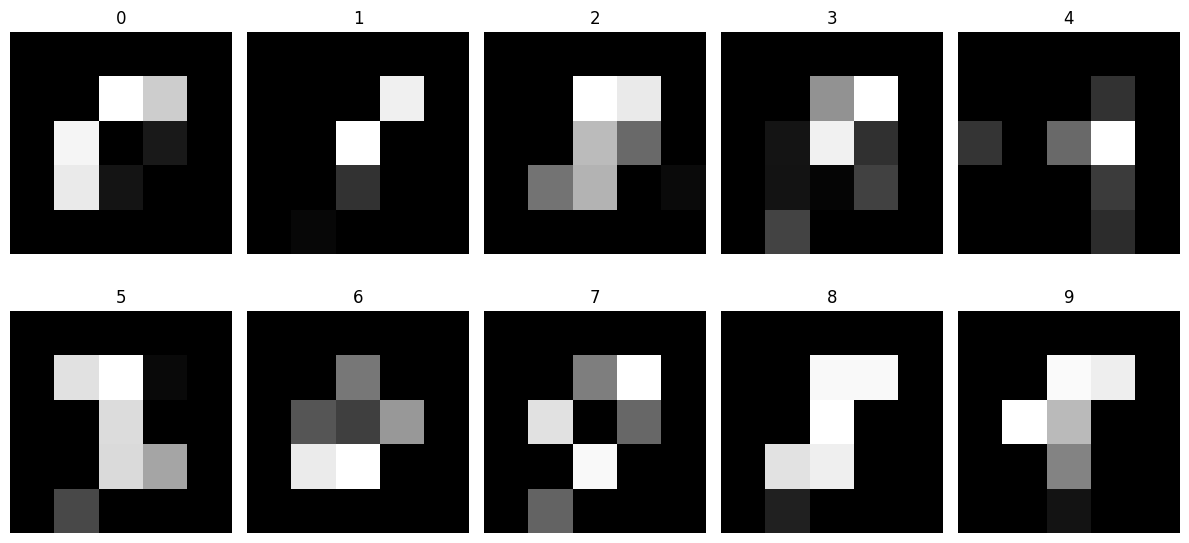

In [ ]:
class_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

fig, axes = plt.subplots(2, 5, figsize=(12, 6))  # Create a 2x5 subplot grid

for class_idx, class_label in enumerate(class_labels):
    index = next(idx for idx, (_, label) in enumerate(dataset_train) if label == class_idx)

    image, _ = dataset_train[index]

    row = class_idx // 5  # Calculate the row index (0 or 1)
    col = class_idx % 5   # Calculate the column index (0 to 4)

    axes[row, col].imshow(image.squeeze().numpy(), cmap='gray')
    axes[row, col].axis('off')
    axes[row, col].set_title(class_label)

plt.tight_layout()
plt.show()


In [ ]:
class_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

train_class_counts = [0] * len(class_labels)

for _, label in dataset_train:
    train_class_counts[label] += 1

test_class_counts = [0] * len(class_labels)

for _, label in dataset_test:
    test_class_counts[label] += 1

print("Train Dataset:")
for class_idx, class_label in enumerate(class_labels):
    print(f"Class {class_label}: {train_class_counts[class_idx]} images")

print("\nTest Dataset:")
for class_idx, class_label in enumerate(class_labels):
    print(f"Class {class_label}: {test_class_counts[class_idx]} images")

Train Dataset:
Class 0: 5923 images
Class 1: 6742 images
Class 2: 5958 images
Class 3: 6131 images
Class 4: 5842 images
Class 5: 5421 images
Class 6: 5918 images
Class 7: 6265 images
Class 8: 5851 images
Class 9: 5949 images

Test Dataset:
Class 0: 980 images
Class 1: 1135 images
Class 2: 1032 images
Class 3: 1010 images
Class 4: 982 images
Class 5: 892 images
Class 6: 958 images
Class 7: 1028 images
Class 8: 974 images
Class 9: 1009 images


Now define some functions & classes to Binarise the weights of the network for forward pass.

In [ ]:
def Binarize(tensor,quant_mode='det'):
    if quant_mode=='det':
        return tensor.sign()
    else:
        return tensor.add_(1).div_(2).add_(torch.rand(tensor.size()).add(-0.5)).clamp_(0,1).round().mul_(2).add_(-1)

In [ ]:
class BinarizeLinear(nn.Linear):

    def __init__(self, *kargs, **kwargs):
        super(BinarizeLinear, self).__init__(*kargs, **kwargs)

    def forward(self, input):

        if input.size(1) != 100:
            input.data=Binarize(input.data)
        if not hasattr(self.weight,'org'):
            self.weight.org=self.weight.data.clone()
        self.weight.data=Binarize(self.weight.org)
        out = nn.functional.linear(input, self.weight)
        if not self.bias is None:
            self.bias.org=self.bias.data.clone()
            out += self.bias.view(1, -1).expand_as(out)

        return out

Train Function, in which the weights are binairsed for every forward pass by clampign them to 1 & -1. while the back prop is done on real set of teh weights, that are gotten rid of after training.

In [ ]:
def train(epoch):
    model.train()
    for i, (data, target) in enumerate(train_loader):

        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)

        loss = criterion(output, target)

        if epoch%25==0:
            optimizer.param_groups[0]['lr']=optimizer.param_groups[0]['lr']*0.1
        optimizer.zero_grad()

        loss.backward()

        for p in list(model.parameters()):
            if hasattr(p,'org'):
                p.data.copy_(p.org)
        optimizer.step()

        for p in list(model.parameters()):
            if hasattr(p,'org'):
                p.org.copy_(p.data.clamp_(-1,1))

        if i % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(data), len(train_loader.dataset),
                100. * i / len(train_loader), loss.item()))

Test Fucntion

In [ ]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return accuracy

Now a BNN is defined with a single block & 20 neurons in the hidden layer. 25 in the input & 10 in the output.

In [ ]:
class BNN_1blk_20(nn.Module):
    def __init__(self, input_size, output_size):
        super(BNN_1blk_20, self).__init__()
        self.infl_ratio=1
        self.input_size=input_size
        self.output_size=output_size
        self.num_internal_blocks=1

        self.name='bnn_1blk_20'
        self.fc1 = BinarizeLinear(input_size,20*self.infl_ratio)
        self.htanh1 = nn.Hardtanh()
        self.bn1 = nn.BatchNorm1d(20*self.infl_ratio)

        self.fc5 = BinarizeLinear(20*self.infl_ratio,output_size)
        self.logsoftmax=nn.LogSoftmax()
        self.binarize_func=Binarize

    def forward(self, x):
        x = x.view(-1, self.input_size)
        x = self.binarize_func(x)

        x = self.fc1(x)
        x = self.bn1(x)
        x = self.htanh1(x)

        x = self.fc5(x)
        return self.logsoftmax(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BNN_1blk_20(25,10)
model=model.to(device)


Training & Evaluation

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.00001, momentum=0.9)

#max_acc = 0.0

for epoch in range(1, 11):
    train(epoch)
    acc = test()

    if acc > max_acc:
        max_acc = acc
        torch.save(model.state_dict(), 'mnist-25-bnn_1blk_20.pt', _use_new_zipfile_serialization=False)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.776451
Train Epoch: 1 [40960/60000 (67%)]	Loss: 2.354612

Test set: Average loss: 0.0007, Accuracy: 3128/10000 (31%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.311371
Train Epoch: 2 [40960/60000 (67%)]	Loss: 2.248443

Test set: Average loss: 0.0007, Accuracy: 3852/10000 (39%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.446308
Train Epoch: 3 [40960/60000 (67%)]	Loss: 2.378898

Test set: Average loss: 0.0007, Accuracy: 3516/10000 (35%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 2.377100
Train Epoch: 4 [40960/60000 (67%)]	Loss: 2.340458

Test set: Average loss: 0.0007, Accuracy: 4320/10000 (43%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 2.463075
Train Epoch: 5 [40960/60000 (67%)]	Loss: 2.404183

Test set: Average loss: 0.0007, Accuracy: 3246/10000 (32%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 2.434546
Train Epoch: 6 [40960/60000 (67%)]	Loss: 2.327264

Test set: Average loss: 0.0007, Accuracy: 3897/10000 (39%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 2.277965
Train Epoch: 7 [409

Loading the saved model for the Testing.

In [ ]:
# Load the model
saved_model = BNN_1blk_20(25,10)
saved_model.load_state_dict(torch.load('/content/drive/MyDrive/5x5/mnist-25-bnn_1blk_20.pt'))
saved_model.to(device)

criterion = nn.CrossEntropyLoss()

def saved_test():
    saved_model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = saved_model(data)
            test_loss += criterion(output, target).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return accuracy

accuracy = saved_test()

print("Accuracy:", accuracy)


Test set: Average loss: 0.0007, Accuracy: 4320/10000 (43%)

Accuracy: tensor(43.2000)


The layers in the model and the weights therein are as follows

In [ ]:
print(saved_model)

BNN_1blk_20(
  (fc1): BinarizeLinear(in_features=25, out_features=20, bias=True)
  (htanh1): Hardtanh(min_val=-1.0, max_val=1.0)
  (bn1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): BinarizeLinear(in_features=20, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=None)
)


In [ ]:
for name, param in saved_model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc1.weight tensor([[ 1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1., -1.,  1., -1., -1.,  1.,
          1., -1., -1.,  1., -1.,  1.,  1., -1., -1.,  1.,  1.],
        [ 1.,  1., -1.,  1., -1., -1., -1., -1., -1.,  1., -1.,  1.,  1.,  1.,
          1., -1., -1., -1., -1., -1., -1., -1., -1.,  1., -1.],
        [ 1., -1., -1., -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1.,  1.,  1.,
         -1.,  1., -1., -1., -1., -1., -1.,  1.,  1.,  1., -1.],
        [ 1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,
          1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1., -1.],
        [-1., -1., -1., -1.,  1., -1., -1.,  1.,  1.,  1., -1.,  1.,  1., -1.,
         -1., -1.,  1.,  1., -1.,  1., -1.,  1.,  1.,  1., -1.],
        [-1.,  1.,  1.,  1., -1., -1.,  1., -1., -1.,  1., -1.,  1., -1.,  1.,
          1., -1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1.],
        [-1.,  1., -1., -1., -1.,  1.,  1., -1.,  1.,  1., -1., -1.,  1.,  1.,
         -1.,  1.,  1., -1.,  1.,  1.,  1.,  1

The two weight matrices fc1 & fc5 can be visualised as follows.

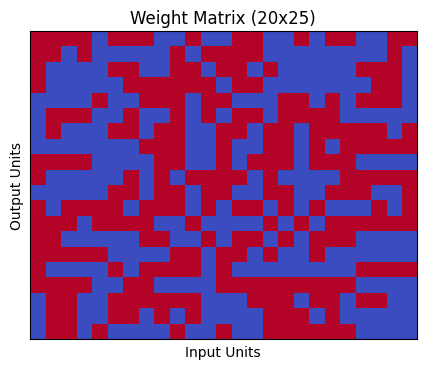

In [ ]:
# Extract the weight matrix from the self.fc1 layer
weight_matrix = saved_model.fc1.weight.data.cpu().numpy()

# Set the figure size to make the plot larger
plt.figure(figsize=(5, 4))  # Adjust the values as needed

# Plot the weight matrix
plt.imshow(weight_matrix, cmap='coolwarm', aspect='auto')  # 'aspect' ensures proper scaling
plt.title('Weight Matrix (20x25)')  # Corrected labels
plt.xlabel('Input Units')  # Corrected label
plt.ylabel('Output Units')  # Corrected label

# Remove ticks from both axes
plt.xticks([])
plt.yticks([])

plt.show()

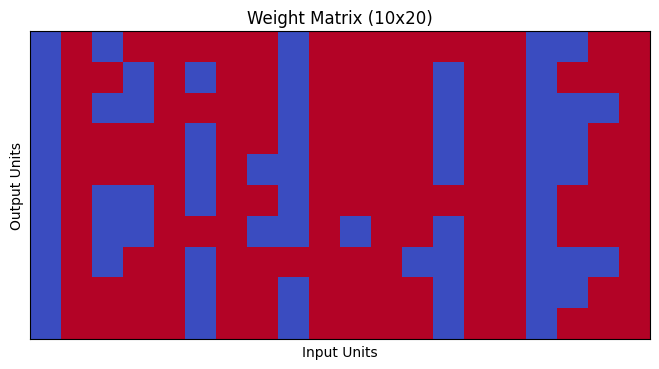

In [ ]:
# Extract the weight matrix from the self.fc1 layer
weight_matrix = saved_model.fc5.weight.data.cpu().numpy()

# Set the figure size to make the plot larger
plt.figure(figsize=(8, 4))  # Adjust the values as needed

# Plot the weight matrix
plt.imshow(weight_matrix, cmap='coolwarm', aspect='auto')  # 'aspect' ensures proper scaling
plt.title('Weight Matrix (10x20)')  # Corrected labels
plt.xlabel('Input Units')  # Corrected label
plt.ylabel('Output Units')  # Corrected label

# Remove ticks from both axes
plt.xticks([])
plt.yticks([])

plt.show()

The BNN defined above has a single block that includes fc1, bn1, tanh1.

This is then followed by the output block with fc5 & softmax.

The inputs to & the outputs from the block are binarised & can hence be encoded as CNF formulas.

I have used an availabe tool, [NPAQ](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjw9sPCgLqCAxUUrVYBHSBBCAMQFnoECAoQAQ&url=https%3A%2F%2Fgithub.com%2Fteobaluta%2FNPAQ&usg=AOvVaw2nCo_P_isYRPC5LD4feVF7&opi=89978449) to convert the above trained pytorch model of a BNN into its corresponding CNF formula.

NPAQ has some specific environment/OS requiremnenst, hence was done locally.

The trained pytorch model for above model definition is & The generated CNF formula for the same is included in the supplemenatry material.

The CNF formulas generated for a small BNN above has

p cnf 5949 13031

variables & clauses, hence i went with a simpler network for demonstration.



While the trained Pytorch model is aroung 43% accurate at classifying MNIST digits, it is of interest to know if the model is aware of what differnt digits in the MNIST dataset looklike.

Network Inversion can provide us access to the input space of the model for a given output label. To perform inversion we append additional clauses to the above CNF formula that constraint the output to take a particular value.

After doing so we look for Satisfying assignmnets for the CNF Formula and using the satisying assignmnets for the inputs we can now recnstruct the inputs that will have the same label as it was restricted to above.

To get better idea of the input space the for a particular output label, we uniformly sample from the input space using [cmsgen](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiRg__XlbuCAxXLp1YBHYUYDx0QFnoECBAQAQ&url=https%3A%2F%2Fgithub.com%2Fmeelgroup%2Fcmsgen&usg=AOvVaw3nh6pCiLPmCMo1RvioYQaa&opi=89978449), an almost uniform sampler that allows us to visualsie the entire input space.

Using the satisfying assignments of CNF formula for different output labels constraints, we can reconstruct the ipnut images for each of the labels.

The reconstructed images for the differnet output labels are also part of the supplementary material and visualised below for labels from 0 to 9 respectively.


In [ ]:
def visualize_images(image_folder):
    # Get a list of image file names in the folder
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]

    # Take the first 10 images for visualization (adjust as needed)
    selected_images = image_files[:10]

    # Create a 1x5 subplot for visualization
    fig, axes = plt.subplots(1, 10, figsize=(15, 3))

    # Load and display the selected images in the subplot
    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(image_folder, image_file)
        image = cv2.imread(image_path)
        axes[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[i].set_title(f'Image {i+1}')
        axes[i].axis('off')

    # Adjust spacing between subplots for clarity
    plt.tight_layout()

    # Show the visualization
    plt.show()

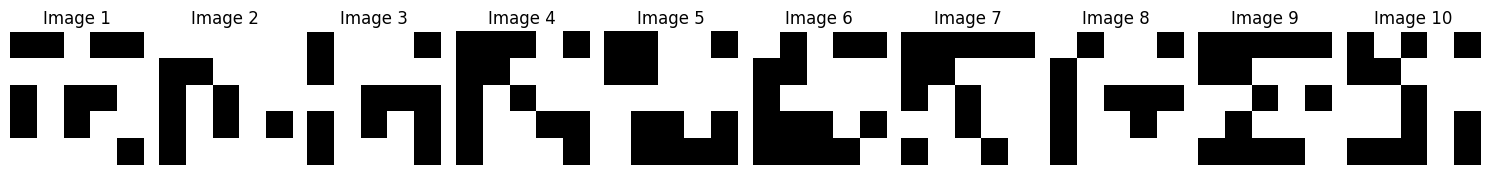

In [ ]:
image_folder_path = '/content/drive/MyDrive/5x5/Images/5x5_0'
visualize_images(image_folder_path)

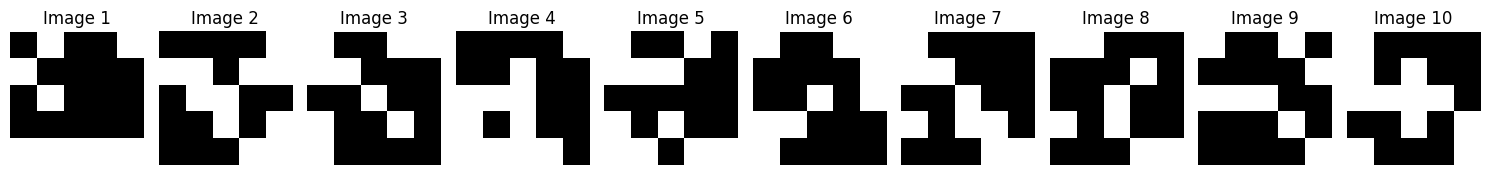

In [ ]:
image_folder_path = '/content/drive/MyDrive/5x5/Images/5x5_1'
visualize_images(image_folder_path)

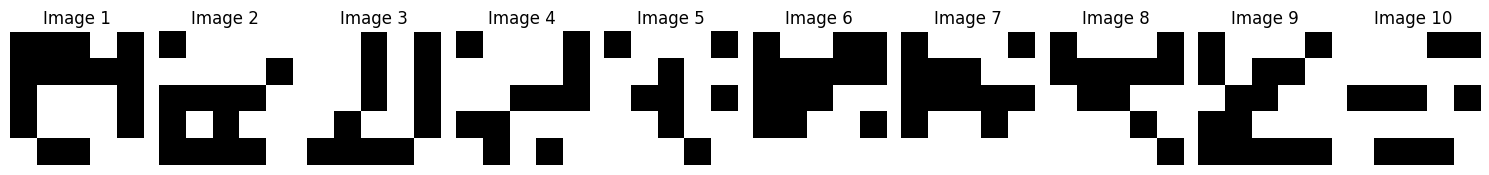

In [ ]:
image_folder_path = '/content/drive/MyDrive/5x5/Images/5x5_2'
visualize_images(image_folder_path)

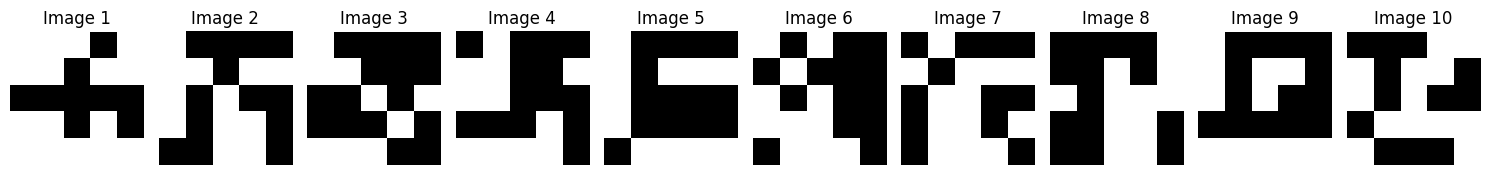

In [ ]:
image_folder_path = '/content/drive/MyDrive/5x5/Images/5x5_3'
visualize_images(image_folder_path)

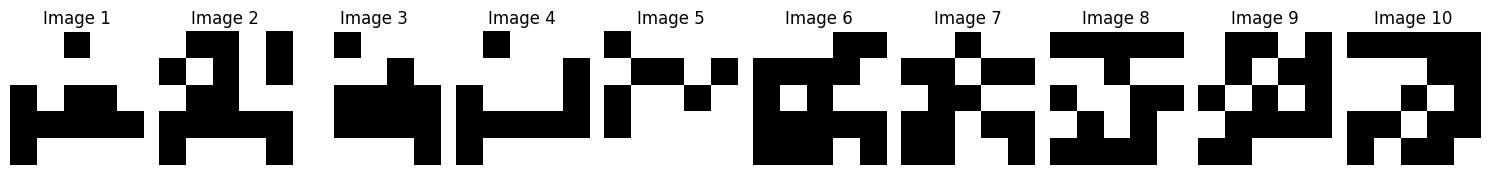

In [ ]:
image_folder_path = '/content/drive/MyDrive/5x5/Images/5x5_4'
visualize_images(image_folder_path)

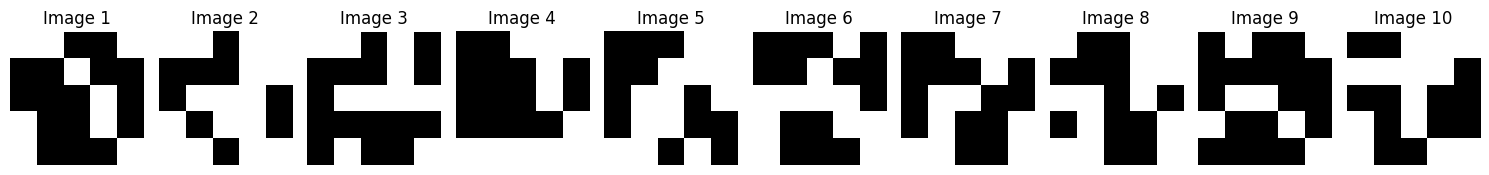

In [ ]:
image_folder_path = '/content/drive/MyDrive/5x5/Images/5x5_5'
visualize_images(image_folder_path)

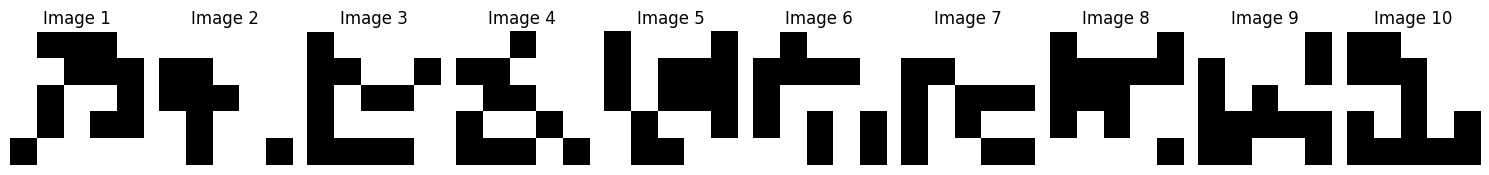

In [ ]:
image_folder_path = '/content/drive/MyDrive/5x5/Images/5x5_6'
visualize_images(image_folder_path)

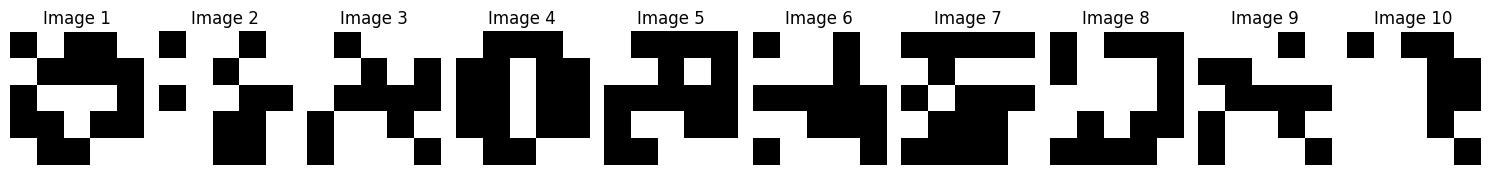

In [ ]:
image_folder_path = '/content/drive/MyDrive/5x5/Images/5x5_7'
visualize_images(image_folder_path)

Although not of interest, the accuracy of the trained model that was encoded is 43%.

From the predicted labels below, we can observe that the model does not output a label 8 to any of the inputs.

This was further verified during the sampling process of the encoded CNF Formula constrainted to produce inputs for the output label 8 which did not return any SAT assignments.

In [ ]:
# Load the model
saved_model = BNN_1blk_20(25,10)

saved_model.load_state_dict(torch.load('/content/drive/MyDrive/5x5/mnist-25-bnn_1blk_20.pt'))
saved_model.to(device)

criterion = nn.CrossEntropyLoss()

def saved_test():
    saved_model.eval()
    test_loss = 0
    correct = 0
    predicted_eight = False
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = saved_model(data)
            test_loss += criterion(output, target).item()
            pred = output.data.max(1, keepdim=True)[1]
            # Look for 8 in the output labels
            if 8 in pred.cpu().numpy():
                predicted_eight = True
            # Print true and predicted labels for each image
            for true_label, predicted_label in zip(target.cpu().numpy(), pred.cpu().numpy()):
                print(f'True Label: {true_label}, Predicted Label: {predicted_label}')
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return accuracy, predicted_eight

accuracy, label_eight = saved_test()

print("Accuracy:", accuracy)
print("Presence of Output 8:", label_eight)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Streaming output truncated to the last 5000 lines.
True Label: 1, Predicted Label: [1]
True Label: 0, Predicted Label: [6]
True Label: 6, Predicted Label: [6]
True Label: 0, Predicted Label: [4]
True Label: 9, Predicted Label: [7]
True Label: 6, Predicted Label: [6]
True Label: 8, Predicted Label: [2]
True Label: 6, Predicted Label: [6]
True Label: 1, Predicted Label: [1]
True Label: 1, Predicted Label: [1]
True Label: 9, Predicted Label: [4]
True Label: 8, Predicted Label: [9]
True Label: 9, Predicted Label: [7]
True Label: 2, Predicted Label: [2]
True Label: 3, Predicted Label: [2]
True Label: 5, Predicted Label: [3]
True Label: 5, Predicted Label: [7]
True Label: 9, Predicted Label: [7]
True Label: 4, Predicted Label: [4]
True Label: 2, Predicted Label: [2]
True Label: 1, Predicted Label: [1]
True Label: 9, Predicted Label: [9]
True Label: 4, Predicted Label: [4]
True Label: 3, Predicted Label: [3]
True Label: 9, Predicted Label: [9]
True Label: 6, Predicted Label: [6]
True Label: 0

Hence the empty folder below.

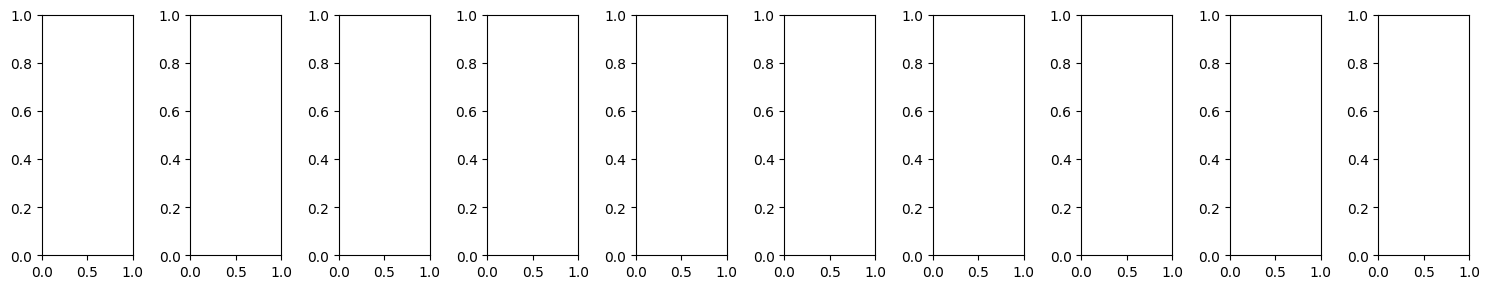

In [ ]:
image_folder_path = '/content/drive/MyDrive/5x5/Images/5x5_8'
visualize_images(image_folder_path)

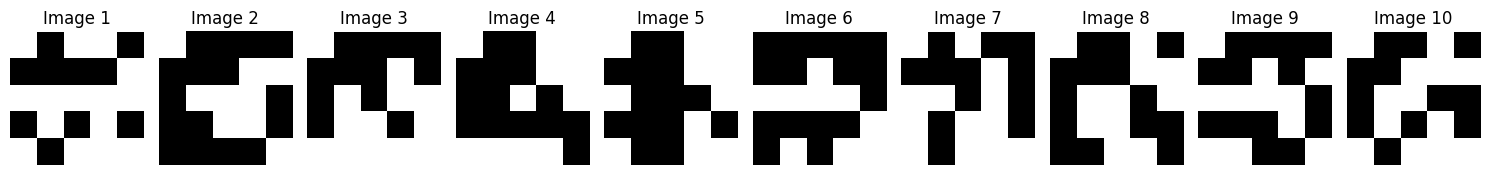

In [ ]:
image_folder_path = '/content/drive/MyDrive/5x5/Images/5x5_9'
visualize_images(image_folder_path)

Now to verify that the reconstrucetd images indeed haev the same output label, the imaegs are forward passed through the saved pytorch model after going through the same normalisation, resize transformation.


In [ ]:
from PIL import Image
import os
saved_model.eval()
saved_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize((0.1307,), (0.3081,)),
])

def get_prediction(image_path):
    image = Image.open(image_path)  # Open the image using PIL
    image = saved_transform(image)  # Apply transformations to the image
    image = image.unsqueeze(0)  # Add a batch dimension to the image
    image = image.to(device)
    with torch.no_grad():
        output = saved_model(image)  # Perform the forward pass
        _, predicted = torch.max(output, 1)  # Get the index of the predicted class

    return predicted.item()  # Return the predicted label as an integer

In [ ]:

folder_path = '/content/drive/MyDrive/5x5/Images/5x5_0'  # Path to the folder containing the images

for i in range(1, 101):
    image_name = f"image{i}.png"
    image_path = os.path.join(folder_path, image_name)
    predicted_label = get_prediction(image_path)
    print(f"Image: {image_name}, Predicted Label: {predicted_label}")

Image: image1.png, Predicted Label: 0
Image: image2.png, Predicted Label: 0
Image: image3.png, Predicted Label: 0
Image: image4.png, Predicted Label: 0
Image: image5.png, Predicted Label: 0
Image: image6.png, Predicted Label: 0
Image: image7.png, Predicted Label: 0
Image: image8.png, Predicted Label: 0
Image: image9.png, Predicted Label: 0
Image: image10.png, Predicted Label: 0
Image: image11.png, Predicted Label: 0
Image: image12.png, Predicted Label: 0
Image: image13.png, Predicted Label: 0
Image: image14.png, Predicted Label: 0
Image: image15.png, Predicted Label: 0
Image: image16.png, Predicted Label: 0
Image: image17.png, Predicted Label: 0
Image: image18.png, Predicted Label: 0
Image: image19.png, Predicted Label: 0
Image: image20.png, Predicted Label: 0
Image: image21.png, Predicted Label: 0
Image: image22.png, Predicted Label: 0
Image: image23.png, Predicted Label: 0
Image: image24.png, Predicted Label: 0
Image: image25.png, Predicted Label: 0
Image: image26.png, Predicted Labe

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
folder_path = '/content/drive/MyDrive/5x5/Images/5x5_1'  # Path to the folder containing the images

for i in range(1, 101):
    image_name = f"image{i}.png"
    image_path = os.path.join(folder_path, image_name)
    predicted_label = get_prediction(image_path)
    print(f"Image: {image_name}, Predicted Label: {predicted_label}")

Image: image1.png, Predicted Label: 1
Image: image2.png, Predicted Label: 1
Image: image3.png, Predicted Label: 1
Image: image4.png, Predicted Label: 1
Image: image5.png, Predicted Label: 1
Image: image6.png, Predicted Label: 1
Image: image7.png, Predicted Label: 1
Image: image8.png, Predicted Label: 1
Image: image9.png, Predicted Label: 1
Image: image10.png, Predicted Label: 1
Image: image11.png, Predicted Label: 1
Image: image12.png, Predicted Label: 1
Image: image13.png, Predicted Label: 1
Image: image14.png, Predicted Label: 1
Image: image15.png, Predicted Label: 1
Image: image16.png, Predicted Label: 1
Image: image17.png, Predicted Label: 1
Image: image18.png, Predicted Label: 1
Image: image19.png, Predicted Label: 1
Image: image20.png, Predicted Label: 1
Image: image21.png, Predicted Label: 1
Image: image22.png, Predicted Label: 1
Image: image23.png, Predicted Label: 1
Image: image24.png, Predicted Label: 1
Image: image25.png, Predicted Label: 1
Image: image26.png, Predicted Labe

In [ ]:
folder_path = '/content/drive/MyDrive/5x5/Images/5x5_2'  # Path to the folder containing the images

for i in range(1, 31):
    image_name = f"image{i}.png"
    image_path = os.path.join(folder_path, image_name)
    predicted_label = get_prediction(image_path)
    print(f"Image: {image_name}, Predicted Label: {predicted_label}")

Image: image1.png, Predicted Label: 2
Image: image2.png, Predicted Label: 2
Image: image3.png, Predicted Label: 2
Image: image4.png, Predicted Label: 2
Image: image5.png, Predicted Label: 2
Image: image6.png, Predicted Label: 2
Image: image7.png, Predicted Label: 2
Image: image8.png, Predicted Label: 2
Image: image9.png, Predicted Label: 2
Image: image10.png, Predicted Label: 2
Image: image11.png, Predicted Label: 2
Image: image12.png, Predicted Label: 2
Image: image13.png, Predicted Label: 2
Image: image14.png, Predicted Label: 2
Image: image15.png, Predicted Label: 2
Image: image16.png, Predicted Label: 2
Image: image17.png, Predicted Label: 2
Image: image18.png, Predicted Label: 2
Image: image19.png, Predicted Label: 2
Image: image20.png, Predicted Label: 2
Image: image21.png, Predicted Label: 2
Image: image22.png, Predicted Label: 2
Image: image23.png, Predicted Label: 2
Image: image24.png, Predicted Label: 2
Image: image25.png, Predicted Label: 2
Image: image26.png, Predicted Labe

In [ ]:
folder_path = '/content/drive/MyDrive/5x5/Images/5x5_3'  # Path to the folder containing the images

for i in range(1, 101):
    image_name = f"image{i}.png"
    image_path = os.path.join(folder_path, image_name)
    predicted_label = get_prediction(image_path)
    print(f"Image: {image_name}, Predicted Label: {predicted_label}")

Image: image1.png, Predicted Label: 3
Image: image2.png, Predicted Label: 3
Image: image3.png, Predicted Label: 3
Image: image4.png, Predicted Label: 3
Image: image5.png, Predicted Label: 3
Image: image6.png, Predicted Label: 3
Image: image7.png, Predicted Label: 3
Image: image8.png, Predicted Label: 3
Image: image9.png, Predicted Label: 3
Image: image10.png, Predicted Label: 3
Image: image11.png, Predicted Label: 3
Image: image12.png, Predicted Label: 3
Image: image13.png, Predicted Label: 3
Image: image14.png, Predicted Label: 3
Image: image15.png, Predicted Label: 3
Image: image16.png, Predicted Label: 3
Image: image17.png, Predicted Label: 3
Image: image18.png, Predicted Label: 3
Image: image19.png, Predicted Label: 3
Image: image20.png, Predicted Label: 3
Image: image21.png, Predicted Label: 3
Image: image22.png, Predicted Label: 3
Image: image23.png, Predicted Label: 3
Image: image24.png, Predicted Label: 3
Image: image25.png, Predicted Label: 3
Image: image26.png, Predicted Labe

In [ ]:
folder_path = '/content/drive/MyDrive/5x5/Images/5x5_4'  # Path to the folder containing the images

for i in range(1, 101):
    image_name = f"image{i}.png"
    image_path = os.path.join(folder_path, image_name)
    predicted_label = get_prediction(image_path)
    print(f"Image: {image_name}, Predicted Label: {predicted_label}")

Image: image1.png, Predicted Label: 4
Image: image2.png, Predicted Label: 4
Image: image3.png, Predicted Label: 4
Image: image4.png, Predicted Label: 4
Image: image5.png, Predicted Label: 4
Image: image6.png, Predicted Label: 4
Image: image7.png, Predicted Label: 4
Image: image8.png, Predicted Label: 4
Image: image9.png, Predicted Label: 4
Image: image10.png, Predicted Label: 4
Image: image11.png, Predicted Label: 4
Image: image12.png, Predicted Label: 4
Image: image13.png, Predicted Label: 4
Image: image14.png, Predicted Label: 4
Image: image15.png, Predicted Label: 4
Image: image16.png, Predicted Label: 4
Image: image17.png, Predicted Label: 4
Image: image18.png, Predicted Label: 4
Image: image19.png, Predicted Label: 4
Image: image20.png, Predicted Label: 4
Image: image21.png, Predicted Label: 4
Image: image22.png, Predicted Label: 4
Image: image23.png, Predicted Label: 4
Image: image24.png, Predicted Label: 4
Image: image25.png, Predicted Label: 4
Image: image26.png, Predicted Labe

In [ ]:
folder_path = '/content/drive/MyDrive/5x5/Images/5x5_5'  # Path to the folder containing the images

for i in range(1, 101):
    image_name = f"image{i}.png"
    image_path = os.path.join(folder_path, image_name)
    predicted_label = get_prediction(image_path)
    print(f"Image: {image_name}, Predicted Label: {predicted_label}")

Image: image1.png, Predicted Label: 5
Image: image2.png, Predicted Label: 5
Image: image3.png, Predicted Label: 5
Image: image4.png, Predicted Label: 5
Image: image5.png, Predicted Label: 5
Image: image6.png, Predicted Label: 5
Image: image7.png, Predicted Label: 5
Image: image8.png, Predicted Label: 5
Image: image9.png, Predicted Label: 5
Image: image10.png, Predicted Label: 5
Image: image11.png, Predicted Label: 5
Image: image12.png, Predicted Label: 5
Image: image13.png, Predicted Label: 5
Image: image14.png, Predicted Label: 5
Image: image15.png, Predicted Label: 5
Image: image16.png, Predicted Label: 5
Image: image17.png, Predicted Label: 5
Image: image18.png, Predicted Label: 5
Image: image19.png, Predicted Label: 5
Image: image20.png, Predicted Label: 5
Image: image21.png, Predicted Label: 5
Image: image22.png, Predicted Label: 5
Image: image23.png, Predicted Label: 5
Image: image24.png, Predicted Label: 5
Image: image25.png, Predicted Label: 5
Image: image26.png, Predicted Labe

In [ ]:
folder_path = '/content/drive/MyDrive/5x5/Images/5x5_6'  # Path to the folder containing the images

for i in range(1, 101):
    image_name = f"image{i}.png"
    image_path = os.path.join(folder_path, image_name)
    predicted_label = get_prediction(image_path)
    print(f"Image: {image_name}, Predicted Label: {predicted_label}")

Image: image1.png, Predicted Label: 6
Image: image2.png, Predicted Label: 6
Image: image3.png, Predicted Label: 6
Image: image4.png, Predicted Label: 6
Image: image5.png, Predicted Label: 6
Image: image6.png, Predicted Label: 6
Image: image7.png, Predicted Label: 6
Image: image8.png, Predicted Label: 6
Image: image9.png, Predicted Label: 6
Image: image10.png, Predicted Label: 6
Image: image11.png, Predicted Label: 6
Image: image12.png, Predicted Label: 6
Image: image13.png, Predicted Label: 6
Image: image14.png, Predicted Label: 6
Image: image15.png, Predicted Label: 6
Image: image16.png, Predicted Label: 6
Image: image17.png, Predicted Label: 6
Image: image18.png, Predicted Label: 6
Image: image19.png, Predicted Label: 6
Image: image20.png, Predicted Label: 6
Image: image21.png, Predicted Label: 6
Image: image22.png, Predicted Label: 6
Image: image23.png, Predicted Label: 6
Image: image24.png, Predicted Label: 6
Image: image25.png, Predicted Label: 6
Image: image26.png, Predicted Labe

In [ ]:
folder_path = '/content/drive/MyDrive/5x5/Images/5x5_7'  # Path to the folder containing the images

for i in range(1, 101):
    image_name = f"image{i}.png"
    image_path = os.path.join(folder_path, image_name)
    predicted_label = get_prediction(image_path)
    print(f"Image: {image_name}, Predicted Label: {predicted_label}")

Image: image1.png, Predicted Label: 7
Image: image2.png, Predicted Label: 7
Image: image3.png, Predicted Label: 7
Image: image4.png, Predicted Label: 7
Image: image5.png, Predicted Label: 7
Image: image6.png, Predicted Label: 7
Image: image7.png, Predicted Label: 7
Image: image8.png, Predicted Label: 7
Image: image9.png, Predicted Label: 7
Image: image10.png, Predicted Label: 7
Image: image11.png, Predicted Label: 7
Image: image12.png, Predicted Label: 7
Image: image13.png, Predicted Label: 7
Image: image14.png, Predicted Label: 7
Image: image15.png, Predicted Label: 7
Image: image16.png, Predicted Label: 7
Image: image17.png, Predicted Label: 7
Image: image18.png, Predicted Label: 7
Image: image19.png, Predicted Label: 7
Image: image20.png, Predicted Label: 7
Image: image21.png, Predicted Label: 7
Image: image22.png, Predicted Label: 7
Image: image23.png, Predicted Label: 7
Image: image24.png, Predicted Label: 7
Image: image25.png, Predicted Label: 7
Image: image26.png, Predicted Labe

Empty Foler below for the output label of 8.

In [ ]:
folder_path = '/content/drive/MyDrive/5x5/Images/5x5_8'  # Path to the folder containing the images

for i in range(1, 101):
    image_name = f"image{i}.png"
    image_path = os.path.join(folder_path, image_name)
    predicted_label = get_prediction(image_path)
    print(f"Image: {image_name}, Predicted Label: {predicted_label}")

In [ ]:
folder_path = '/content/drive/MyDrive/5x5/Images/5x5_9'  # Path to the folder containing the images

for i in range(1, 101):
    image_name = f"image{i}.png"
    image_path = os.path.join(folder_path, image_name)
    predicted_label = get_prediction(image_path)
    print(f"Image: {image_name}, Predicted Label: {predicted_label}")

Image: image1.png, Predicted Label: 9
Image: image2.png, Predicted Label: 9
Image: image3.png, Predicted Label: 9
Image: image4.png, Predicted Label: 9
Image: image5.png, Predicted Label: 9
Image: image6.png, Predicted Label: 9
Image: image7.png, Predicted Label: 9
Image: image8.png, Predicted Label: 9
Image: image9.png, Predicted Label: 9
Image: image10.png, Predicted Label: 9
Image: image11.png, Predicted Label: 9
Image: image12.png, Predicted Label: 9
Image: image13.png, Predicted Label: 9
Image: image14.png, Predicted Label: 9
Image: image15.png, Predicted Label: 9
Image: image16.png, Predicted Label: 9
Image: image17.png, Predicted Label: 9
Image: image18.png, Predicted Label: 9
Image: image19.png, Predicted Label: 9
Image: image20.png, Predicted Label: 9
Image: image21.png, Predicted Label: 9
Image: image22.png, Predicted Label: 9
Image: image23.png, Predicted Label: 9
Image: image24.png, Predicted Label: 9
Image: image25.png, Predicted Label: 9
Image: image26.png, Predicted Labe

Since all the reconstructed images have the same label, the Network Inversion performed is exact.

The inversion process demonstrates that while the model does a good job classifying MNIST digits, it deos not necessarily imply that the model is in anyway aware of what differnt digits look like.

To refine the model & the decision boundaries, we can use the reconstrucetd images to retrain the model now with an extra class for the above OOD samples after passing them through an oracle or a large model.

The iterative retraining process can be continued till the uniformly sampled reconstructed images from the input space of the newly trained model for a particluar label, start to look like the MNIST digits.

